In [1]:
# https://deeplearningcourses.com/c/deep-learning-convolutional-neural-networks-theano-tensorflow
# https://udemy.com/deep-learning-convolutional-neural-networks-theano-tensorflow
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future
%matplotlib inline
import os
import numpy as np

import matplotlib.pyplot as plt
import tensorflow as tf
from theano.tensor.nnet import conv2d
from theano.tensor.signal import pool

from scipy.io import loadmat
from sklearn.utils import shuffle

from datetime import datetime

In [2]:
def y2indicator(y):
    N = len(y)
    ind = np.zeros((N, 10))
    for i in range(N):
        ind[i, y[i]] = 1
    return ind


def error_rate(p, t):
    return np.mean(p != t)


def flatten(X):
    # input will be (32, 32, 3, N)
    # output will be (N, 3072)
    N = X.shape[-1]
    flat = np.zeros((N, 3072))
    for i in range(N):
        flat[i] = X[:,:,:,i].reshape(3072)
    return flat

def get_data():
    if not os.path.exists('cnn_data/train_32x32.mat'):
        print('Looking for cnn_data/train_32x32.mat')
        print('You have not downloaded the data and/or not placed the files in the correct location.')
        print('Please get the data from: http://ufldl.stanford.edu/housenumbers')
        print('Place train_32x32.mat and test_32x32.mat in the folder large_files adjacent to the class folder')
        exit()

    train = loadmat('cnn_data/train_32x32.mat')
    test  = loadmat('cnn_data/test_32x32.mat')
    return train, test


In [3]:
def convpool(X, W, b):
    # just assume pool size is (2,2) because we need to augment it with 1s
    conv_out = tf.nn.conv2d(X, W, strides=[1, 1, 1, 1], padding='SAME')
    conv_out = tf.nn.bias_add(conv_out, b)
    pool_out = tf.nn.max_pool(conv_out, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    return tf.nn.relu(pool_out)


def init_filter(shape, poolsz):
    w = np.random.randn(*shape) / np.sqrt(np.prod(shape[:-1]) + shape[-1]*np.prod(shape[:-2] / np.prod(poolsz)))
    return w.astype(np.float32)


def rearrange(X):
    # input is (32, 32, 3, N)
    # output is (N, 32, 32, 3)
    # N = X.shape[-1]
    # out = np.zeros((N, 32, 32, 3), dtype=np.float32)
    # for i in xrange(N):
    #     for j in xrange(3):
    #         out[i, :, :, j] = X[:, :, j, i]
    # return out / 255
    return (X.transpose(3, 0, 1, 2) / 255).astype(np.float32)

In [4]:
# step 1: load the data, transform as needed
train, test = get_data()

# Need to scale! don't leave as 0..255
# Y is a N x 1 matrix with values 1..10 (MATLAB indexes by 1)
# So flatten it and make it 0..9
# Also need indicator matrix for cost calculation
Xtrain = rearrange(train['X'])
Ytrain = train['y'].flatten() - 1
del train
Xtrain, Ytrain = shuffle(Xtrain, Ytrain)
Ytrain_ind = y2indicator(Ytrain)

Xtest  = rearrange(test['X'])
Ytest  = test['y'].flatten() - 1
del test
Ytest_ind  = y2indicator(Ytest)

In [5]:
# gradient descent params
max_iter = 6
print_period = 10
N = Xtrain.shape[0]
batch_sz = 500
n_batches = N // batch_sz

# limit samples since input will always have to be same size
# you could also just do N = N / batch_sz * batch_sz
Xtrain = Xtrain[:73000,]
Ytrain = Ytrain[:73000]
Xtest = Xtest[:26000,]
Ytest = Ytest[:26000]
Ytest_ind = Ytest_ind[:26000,]
# print "Xtest.shape:", Xtest.shape
# print "Ytest.shape:", Ytest.shape

# initial weights
M = 500
K = 10
poolsz = (2, 2)

In [6]:
W1_shape = (5, 5, 3, 20) # (filter_width, filter_height, num_color_channels, num_feature_maps)
W1_init = init_filter(W1_shape, poolsz)
b1_init = np.zeros(W1_shape[-1], dtype=np.float32) # one bias per output feature map

W2_shape = (5, 5, 20, 50) # (filter_width, filter_height, old_num_feature_maps, num_feature_maps)
W2_init = init_filter(W2_shape, poolsz)
b2_init = np.zeros(W2_shape[-1], dtype=np.float32)

# vanilla ANN weights
W3_init = np.random.randn(W2_shape[-1]*8*8, M) / np.sqrt(W2_shape[-1]*8*8 + M)
b3_init = np.zeros(M, dtype=np.float32)
W4_init = np.random.randn(M, K) / np.sqrt(M + K)
b4_init = np.zeros(K, dtype=np.float32)

In [7]:
# define variables and expressions
# using None as the first shape element takes up too much RAM unfortunately
X = tf.placeholder(tf.float32, shape=(batch_sz, 32, 32, 3), name='X')
T = tf.placeholder(tf.float32, shape=(batch_sz, K), name='T')
W1 = tf.Variable(W1_init.astype(np.float32))
b1 = tf.Variable(b1_init.astype(np.float32))
W2 = tf.Variable(W2_init.astype(np.float32))
b2 = tf.Variable(b2_init.astype(np.float32))
W3 = tf.Variable(W3_init.astype(np.float32))
b3 = tf.Variable(b3_init.astype(np.float32))
W4 = tf.Variable(W4_init.astype(np.float32))
b4 = tf.Variable(b4_init.astype(np.float32))

Z1 = convpool(X, W1, b1)
Z2 = convpool(Z1, W2, b2)
Z2_shape = Z2.get_shape().as_list()
Z2r = tf.reshape(Z2, [Z2_shape[0], np.prod(Z2_shape[1:])])
Z3 = tf.nn.relu( tf.matmul(Z2r, W3) + b3 )
Yish = tf.matmul(Z3, W4) + b4

cost = tf.reduce_sum(
    tf.nn.softmax_cross_entropy_with_logits(
        logits=Yish,
        labels=T
    )
)

train_op = tf.train.RMSPropOptimizer(0.0001, decay=0.99, momentum=0.9).minimize(cost)

# we'll use this to calculate the error rate
predict_op = tf.argmax(Yish, 1)

Cost / err at iteration i=0, j=0: 58387.527 / 0.804
Cost / err at iteration i=0, j=10: 58028.305 / 0.804
Cost / err at iteration i=0, j=20: 57776.788 / 0.804
Cost / err at iteration i=0, j=30: 57396.051 / 0.803
Cost / err at iteration i=0, j=40: 56454.384 / 0.765
Cost / err at iteration i=0, j=50: 54503.637 / 0.789
Cost / err at iteration i=0, j=60: 48492.393 / 0.633
Cost / err at iteration i=0, j=70: 41480.959 / 0.482
Cost / err at iteration i=0, j=80: 35213.522 / 0.433
Cost / err at iteration i=0, j=90: 31157.866 / 0.360
Cost / err at iteration i=0, j=100: 28214.737 / 0.334
Cost / err at iteration i=0, j=110: 26661.535 / 0.311
Cost / err at iteration i=0, j=120: 24936.749 / 0.274
Cost / err at iteration i=0, j=130: 23093.513 / 0.255
Cost / err at iteration i=0, j=140: 22252.962 / 0.246
Cost / err at iteration i=1, j=0: 21147.357 / 0.232
Cost / err at iteration i=1, j=10: 20122.952 / 0.220
Cost / err at iteration i=1, j=20: 18561.555 / 0.197
Cost / err at iteration i=1, j=30: 18204.04

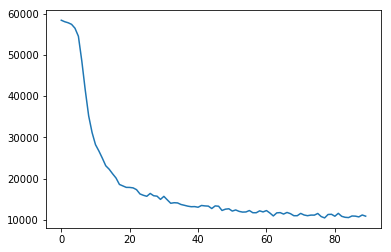

In [8]:
t0 = datetime.now()
LL = []
init = tf.global_variables_initializer()
with tf.Session() as session:
    session.run(init)

    for i in range(max_iter):
        for j in range(n_batches):
            Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
            Ybatch = Ytrain_ind[j*batch_sz:(j*batch_sz + batch_sz),]

            if len(Xbatch) == batch_sz:
                session.run(train_op, feed_dict={X: Xbatch, T: Ybatch})
                if j % print_period == 0:
                    # due to RAM limitations we need to have a fixed size input
                    # so as a result, we have this ugly total cost and prediction computation
                    test_cost = 0
                    prediction = np.zeros(len(Xtest))
                    for k in range(len(Xtest) // batch_sz):
                        Xtestbatch = Xtest[k*batch_sz:(k*batch_sz + batch_sz),]
                        Ytestbatch = Ytest_ind[k*batch_sz:(k*batch_sz + batch_sz),]
                        test_cost += session.run(cost, feed_dict={X: Xtestbatch, T: Ytestbatch})
                        prediction[k*batch_sz:(k*batch_sz + batch_sz)] = session.run(
                            predict_op, feed_dict={X: Xtestbatch})
                    err = error_rate(prediction, Ytest)
                    print("Cost / err at iteration i=%d, j=%d: %.3f / %.3f" % (i, j, test_cost, err))
                    LL.append(test_cost)
print("Elapsed time:", (datetime.now() - t0))
plt.plot(LL)
plt.show()